# <center>ESCI 445 - 1D Shallow-water Model

We will program a 1D Shallow-water Model with rotation.  The equations we will use are:

$$
\frac{\partial u}{\partial t} = -g\frac{\partial \eta}{\partial x} + fv
$$

$$
\frac{\partial v}{\partial t} = -fu
$$

$$
\frac{\partial \eta}{\partial t} = -H\frac{\partial u}{\partial x}.
$$

We will use a staggered grid and the following parameters:

* Grid points:
    * 401 for $u$ and $v$
    * 400 for $\eta$
* Time scheme:  3rd-order Adams-Bashforth
* Space differencing: centered
* Boundary conditions: radiation at both boundaries, with known wave speed $c = \sqrt{gH}$.
* Depth:  $H = 10.0\text{ m}$
* Gravity:  $g = 9.806651\text{ m s}^{-2}$

* Coriolis parameter:  $f = 10^{-4}\text{ s}^{-1}$
* Time increment:  $\Delta t =  30\text{ s}$
* Grid spacing: $d = 3000\text{ m}$
* Total iterations: 64,000 (to allow to come to steady state)

The initial conditions are either a step or a box.

Further notes:

* The lateral boundary conditions only need to be applied to $u$.  You do not need boundary conditions for $v$ or $\eta$
* You can animate the program output using the same viewing program as for Exercise 4.
    * If you want to keep your different output files, be sure to rename them after they are created.

### Import Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

### Set Up Some Model Parameters

In [11]:
# Set up grid parameters
N_total = 64000     # final time level
n_save = 80         # time levels between saves
nx_eta = 400        # number of height grid points
nx_u = nx_eta + 1   # number of velocity points
dx = 3000.0         # grid spacing (meters)
dt = 30.0           # time increment (seconds)
H = 10.0            # depth (meters)
g = 9.80665         # gravity (m/s^2)
c = np.sqrt(g*H)    # wave speed (m/s)
f = 1e-4            # Coriolis parameter (s^-1)

Rossby_radius = c/f     # Rossby radius of deformation (meters)

### Set Up Model Arrays

In [12]:
# Arrays for height
eta_now = np.zeros(nx_eta, dtype = np.float_)  # Height at n
eta_next = np.zeros_like(eta_now)              # Height at n+1
eta_past = np.zeros_like(eta_now)              # Height at n-1
eta_ancient = np.zeros_like(eta_now)           # Height at n-2

# Arrays for u
u_now = np.zeros(nx_u, dtype = np.float_)  # u at n
u_next = np.zeros_like(u_now)              # u at n+1
u_past = np.zeros_like(u_now)              # u at n-1
u_ancient = np.zeros_like(u_now)           # u at n-2

# Arrays for v
v_now = np.zeros_like(u_now)        # v at n
v_next = np.zeros_like(u_now)       # v at n+1
v_past = np.zeros_like(u_now)       # v at n-1
v_ancient = np.zeros_like(u_now)    # v at n-2

# Array to hold the output values of height
eta = np.zeros((0, nx_eta), dtype = np.float_)

### Initialize Disturbance

In [13]:
step = True   # Choice of step or box disturbance
reverse = +1  # Makes height perturbations positive if +1 or negative if -1

if step:
    eta_now[:int(nx_eta/2)] = reverse*0.9
    eta_now[int(nx_eta/2):] = -reverse*0.9
else:
    width = 100
    i = int(nx_eta/2)-int(width/2)
    j = int(nx_eta/2) + int(width/2) + 1
    eta_now[i:j] = reverse*0.9

# Save initial data
eta = np.vstack((eta, eta_now))
print('Initial data saved.')

Initial data saved.


### <font color = 'blue'><i>*Forward Scheme for First Time Step

In [14]:
n = 0

# New values of uon interior grid points
for i in range (1,nx_u-1):
    u_next[i] = u_now[i] + 1/dt*((-g/dx)*(eta_now[i]-eta_now[i-1])+f*dt*v_now[i])

# New values of v and eta on entire grid        
for i in range (0,nx_u):
    v_next[i] = v_now[i] - f *dt* (u_now[i])
for i in range (0,nx_eta):
    eta_next[i] = eta_now[i] - H*(dt/dx) * (u_now[i+1]-u_now[i])


# Apply boundary conditions for u (<< VAR ON BOUNDRY)
u_next[0] = u_now[0] + (dt*abs(c))/dx * (u_now[1]-u_now[0])
    
u_next[-1] = u_now[-1] - (dt*abs(c))/dx * (u_now[-1]-u_now[-2])

# c = sqrt(g*h) Given


# Swap variables
u_past = np.copy(u_now)
u_now = np.copy(u_next)
v_past = np.copy(v_now)
v_now = np.copy(v_next)
eta_past = np.copy(eta_now)
eta_now = np.copy(eta_next)


### <font color = 'blue'><i>*Leapfrog Scheme for second Time Step

In [15]:
n = 1

# New values of u on interior grid points
for i in range (1,nx_u-1):
    u_next[i] = u_past[i] - 2*g*(dt/dx)*(eta_now[i]-eta_now[i-1])+2*f*v_now[i]

# New values of v and eta on entire grid
for i in range (0,nx_u):
    v_next[i] = v_past[i] - 2*f*dt*(u_now[i])
for i in range (0,nx_eta):
    eta_next[i] = eta_past[i] - 2*H*(dt/dx)*(u_now[i+1] - u_now[i])

# Apply boundary conditions for u
u_next[0] = u_now[0] + (dt*abs(c))/dx * (u_now[1]-u_now[0])
    
u_next[-1] = u_now[-1] - (dt*abs(c))/dx * (u_now[-1]-u_now[-2])

# Swap variables
u_past = np.copy(u_now)
u_now = np.copy(u_next)
v_past = np.copy(v_now)
v_now = np.copy(v_next)
eta_past = np.copy(eta_now)
eta_now = np.copy(eta_next)

### <font color = 'blue'><i>*Main Loop Over Time with 3rd-order Adams-Bashforth Scheme

In [16]:
for n in range(2, N_total):
    
    # New values of u on interior grid points
    for i in range(1,nx_u-1):
        u_next[i] = u_now[i] - ((g*dt)/(12*dx)) * (23*(eta_now[i] - eta_now[i-1]) - 16 *\
                (eta_past[i] - eta_past[i-1]) + 5*(eta_ancient[i] - eta_ancient[i-1]))+ (dt/12)*f*(23*v_now[i]\
                - 16 *v_past[i] + 5*v_ancient[i])

    
    # New values of v and eta on entire grid
    for i in range(0,nx_u):
        v_next[i] = v_now[i] - (dt/12)*f* (23*u_now[i] - 16 *u_past[i] + 5*u_ancient[i])
    for i in range(0,nx_eta):
        eta_next[i] = eta_now[i] - (dt*H)/(12*dx) * (23*(u_now[i+1] - u_now[i]) - 16 *\
                    (u_past[i+1] - u_past[i]) + 5*(u_ancient[i+1] - u_ancient[i]))
    
    # Apply boundary conditions for u
    u_next[0] = u_now[0] + (dt*abs(c))/dx * (u_now[1]-u_now[0])
    
    u_next[-1] = u_now[-1] - (dt*abs(c))/dx * (u_now[-1]-u_now[-2])
    
    # Swap variables
    u_ancient = np.copy(u_past)
    u_past = np.copy(u_now)
    u_now = np.copy(u_next)
    
    v_ancient = np.copy(v_past)
    v_past = np.copy(v_now)
    v_now = np.copy(v_next)
    
    eta_ancient = np.copy(eta_past)
    eta_past = np.copy(eta_now)
    eta_now = np.copy(eta_next)
    
    # Save data
    if (n+1) % n_save == 0:
        eta = np.vstack((eta, eta_now))
        print('Data saved at time {0:d}.'.format(n+1))

print('Done')

Data saved at time 80.
Data saved at time 160.
Data saved at time 240.
Data saved at time 320.
Data saved at time 400.
Data saved at time 480.
Data saved at time 560.
Data saved at time 640.
Data saved at time 720.
Data saved at time 800.
Data saved at time 880.
Data saved at time 960.
Data saved at time 1040.
Data saved at time 1120.
Data saved at time 1200.
Data saved at time 1280.
Data saved at time 1360.
Data saved at time 1440.
Data saved at time 1520.
Data saved at time 1600.
Data saved at time 1680.
Data saved at time 1760.
Data saved at time 1840.
Data saved at time 1920.
Data saved at time 2000.
Data saved at time 2080.
Data saved at time 2160.
Data saved at time 2240.
Data saved at time 2320.
Data saved at time 2400.
Data saved at time 2480.
Data saved at time 2560.
Data saved at time 2640.
Data saved at time 2720.
Data saved at time 2800.
Data saved at time 2880.
Data saved at time 2960.
Data saved at time 3040.
Data saved at time 3120.
Data saved at time 3200.
Data saved at

### Save output file for later use.  Output can be viewed separately using the program View-1D.py

In [17]:
np.save('1D-Shallow', eta) # Saves output as NumPy array file

### Create Plots

<IPython.core.display.Javascript object>


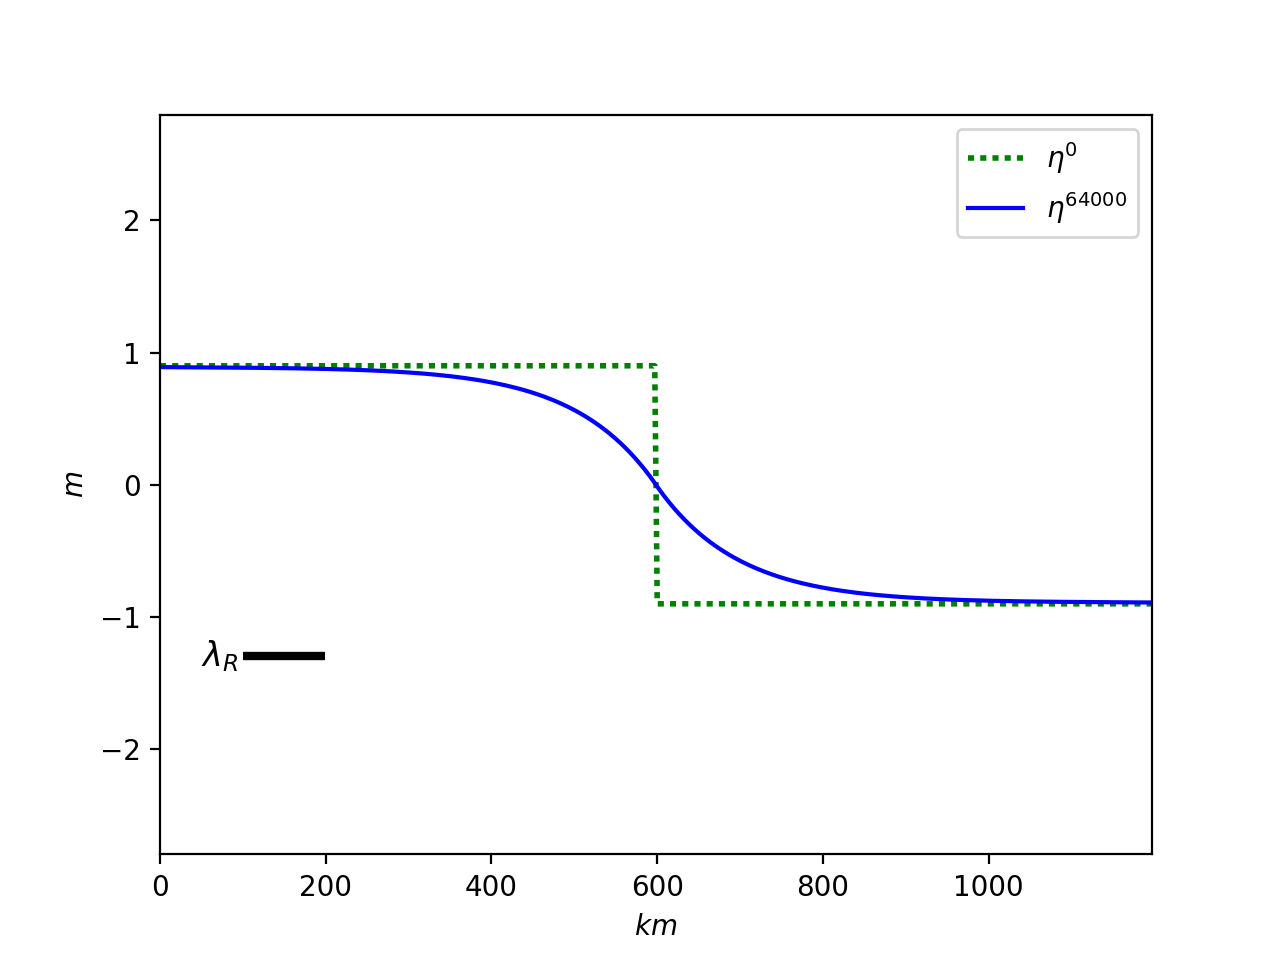

Rossby radius = 99.028531 km


In [18]:
%matplotlib notebook

s = r'$\eta^{' + str(N_total) + r'}$'
x = dx*np.arange(0,nx_eta)/1000
plt.plot(x, eta[0,:], 'g:',label = r'$\eta^0$', lw = 2)
plt.plot(x, eta[-1,:], 'b-',label = s)
plt.xlim(x[0],x[-1])
etamin, etamax = 2*np.min(eta), 2*np.max(eta)
plt.ylim(etamin-0.2, etamax+0.2)
plt.ylabel(r'$m$')
plt.xlabel(r'$km$')
plt.hlines(0.5*etamin, 100, 100+Rossby_radius/1000, lw = 3)
plt.text(50, 0.5*etamin, r'$\lambda_R$', size = 'large', 
         verticalalignment = 'center')

plt.legend((r'$\eta^0$', s), loc = 0)
print('Rossby radius = {0:f} km'.format(Rossby_radius/1000))

plt.show()